# Proof of Concept: Linking Climate Data with CFD Prices for Agricultural Commodities

**Objective:** Evaluate the feasibility of predicting CFD price movements (e.g., cotton) by incorporating monthly (or daily aggregated) climatic data over the last 20 years. This notebook serves as a preliminary investigation using machine learning techniques and exploratory data analysis.

**Outline:**
1. Data Acquisition and Loading
2. Data Preprocessing and Aggregation
3. Exploratory Data Analysis (EDA)
4. Feature Engineering (including creation of climatic indices and lag variables)
5. Modeling: Training a simple ML model (e.g., RandomForest)
6. Model Evaluation and Interpretation
7. Conclusions and Next Steps


## 1. Importing Libraries
Import necessary libraries for data analysis, visualization, and modeling.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# You can add more libraries as needed

%matplotlib inline

## 2. Data Acquisition and Loading
Load the climate and CFD price data. For this PoC, you can use synthetic datasets or CSV samples.

*Example files:*
- `climate_data.csv`: Daily or monthly climate variables (temperature, precipitation, extreme events, etc.)
- `price_data.csv`: Historical CFD price series (e.g., cotton) on a monthly basis

In [3]:
import requests
import geopandas as gpd
from pathlib import Path

# URL del GeoJSON de límites administrativos
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/geojson?lang=en&timezone=Europe%2FBerlin"

# Definir el directorio de salida y el nombre del archivo
output_dir = Path("data_inputs")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "world-administrative-boundaries.geojson"

# Descargar el GeoJSON
response = requests.get(url)
if response.status_code == 200:
    with open(output_file, "wb") as f:
        f.write(response.content)
    print(f"GeoJSON downloaded successfully and saved to {output_file}")
else:
    print("Error downloading file:", response.status_code)

# Cargar el archivo en un GeoDataFrame
gdf = gpd.read_file(output_file)
print(f"GeoDataFrame loaded successfully with {len(gdf)} records.")

GeoJSON downloaded successfully and saved to data_inputs/world-administrative-boundaries.geojson
GeoDataFrame loaded successfully with 256 records.


In [ ]:
import time
import geopandas as gpd
from pathlib import Path
import cdsapi
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuración básica del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ruta del GeoJSON de límites administrativos
shapefile_path = Path("data_inputs/shapefile/world-administrative-boundaries.geojson")

# Cargar el GeoJSON en un GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Filtrar los países principales productores de cacao
countries_of_interest = [
    "Côte d'Ivoire", 
    "Ghana", 
    "Nigeria", 
    "Cameroon", 
    "Togo", 
    "Sierra Leone", 
    "Liberia", 
    "Guinea", 
    "Benin", 
    "Democratic Republic of the Congo"
]
gdf_filtered = gdf[gdf["name"].isin(countries_of_interest)]

# Calcular el bounding box que contiene todos los países filtrados
minx, miny, maxx, maxy = gdf_filtered.total_bounds
# Formato requerido por CDS API: [North, West, South, East]
bounding_box = [maxy, minx, miny, maxx]
logger.info(f"Bounding box para todos los países: {bounding_box}")

# Crear el cliente CDS API (asegúrate de tener configurado el archivo ~/.cdsapirc con tus credenciales)
client = cdsapi.Client()

# Parámetros comunes para la solicitud
dataset = "derived-era5-single-levels-daily-statistics"
year = "2021"
months = [f"{i:02d}" for i in range(1, 13)]
# Lista de días: se incluye del 1 al 31 para que el dataset incluya todos los días del mes
days_list = [f"{i:02d}" for i in range(1, 32)]

# Directorio de salida para guardar los archivos descargados
output_dir = Path("data_inputs/climate_data")
output_dir.mkdir(parents=True, exist_ok=True)

def download_with_retry(request_params, output_file, max_retries=3, initial_delay=10):
    """
    Intenta descargar el archivo utilizando reintentos con backoff exponencial.
    """
    attempt = 1
    delay = initial_delay
    while attempt <= max_retries:
        try:
            logger.info(f"Intento {attempt} para descargar {output_file}...")
            client.retrieve(dataset, request_params).download(str(output_file))
            logger.info(f"Descarga completada en {output_file}.")
            return  # Éxito
        except Exception as e:
            logger.error(f"Error en intento {attempt} para {output_file}: {e}")
            if attempt == max_retries:
                raise
            else:
                logger.info(f"Esperando {delay} segundos antes de reintentar...")
                time.sleep(delay)
                delay *= 2  # Backoff exponencial
                attempt += 1

def download_monthly_data(variable, daily_stat, area, month):
    """
    Descarga datos climáticos para una variable y un mes específico usando el bounding box.
    """
    request_params = {
        "product_type": "reanalysis",
        "variable": [variable],
        "year": year,
        "month": [month],
        "day": days_list,  # Todos los días del mes
        "daily_statistic": daily_stat,
        "time_zone": "utc+00:00",
        "frequency": "1_hourly",
        "area": area
    }
    output_file = output_dir / f"era5_land_{variable}_{year}_ALL_M{month}.nc"
    logger.info(f"Iniciando descarga de {variable} - Mes: {month} en {output_file}...")
    download_with_retry(request_params, output_file)

# Lista de variables y sus correspondientes estadísticos
variables_info = [
    {"variable": "2m_temperature", "daily_statistic": "daily_maximum"},
    {"variable": "total_precipitation", "daily_statistic": "daily_sum"}
]

# Se recomienda utilizar una concurrencia moderada para no saturar la API del CDS.
max_workers = 2
tasks = []

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    for month in months:
        for info in variables_info:
            tasks.append(executor.submit(
                download_monthly_data,
                info["variable"],
                info["daily_statistic"],
                bounding_box,
                month
            ))
    for future in as_completed(tasks):
        try:
            future.result()
        except Exception as e:
            logger.error(f"Error en una tarea de descarga: {e}")

INFO:__main__:Bounding box para todos los países: [np.float64(13.891500000000065), np.float64(-15.080829999999935), np.float64(-13.458059999999932), np.float64(31.30278000000004)]
2025-03-15 01:38:17,260 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-15 01:38:17,267 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
INFO:__main__:Iniciando descarga de 2m_temperature - Mes: 01 en data_inputs/climate_data/era5_land_2m_temperature_2021_ALL_M01.nc...
INFO:__main__:Intento 1 para descargar data_inputs/climate_data/era5_land_2m_temperature_202

In [ ]:
from dask.distributed import Client, LocalCluster

# Inicia un clúster local con la configuración por defecto
cluster = LocalCluster()

# Crea un cliente que se conecte al clúster
client = Client(cluster)

# Muestra la URL del dashboard
print("Dashboard Dask:", client.dashboard_link)

Dashboard Dask: http://127.0.0.1:8787/status


2025-03-15 01:22:56,141 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:22:56,306 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:17,419 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:17,649 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:17,661 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:17,771 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:17,875 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:56,597 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:56,601 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:23:56,725 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:26:49,122 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:26:49,286 - distributed.nanny - WARNING - Restarting worker
2025-03-15 01:26:49,322 - distributed.nanny - WARNING - Restarting worker


In [3]:
import xarray as xr
import glob
from pathlib import Path

# Carpeta donde guardaste los NetCDF
input_dir = Path("data_inputs/climate_data")

# Buscar todos los ficheros .nc
nc_files = sorted(input_dir.glob("*.nc"))

# Abrir todos los NetCDF como un solo dataset
# Si los ficheros tienen coordenadas compatibles, combine="by_coords" suele funcionar bien.
ds = xr.open_mfdataset(
    [str(f) for f in nc_files],  # lista de rutas en string
    combine="by_coords",         # unifica con base en las coords (tiempo, lat, lon, etc.)
    parallel=True                # permite paralelizar si tienes Dask configurado
)

# Opcional: especificar 'chunks' para un mejor rendimiento
# ds = xr.open_mfdataset(
#     [str(f) for f in nc_files],
#     combine="by_coords",
#     parallel=True,
#     chunks={"time": 31, "latitude": 100, "longitude": 100}
# )

# Exportar a Zarr
output_zarr = "era5_land_cacao.zarr"
ds.to_zarr(output_zarr, mode="w")

print(f"Guardado en Zarr: {output_zarr}")

2025-03-15 01:23:17,513 - distributed.worker - ERROR - Compute Failed
Key:       open_dataset-e8eaf76d-d959-4483-918b-73552886e415
State:     executing
Task:  <Task 'open_dataset-e8eaf76d-d959-4483-918b-73552886e415' apply(...)>
Exception: "OSError(-101, 'NetCDF: HDF error')"
Traceback: '  File "/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/dask/utils.py", line 77, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File "/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/xarray/backends/api.py", line 686, in open_dataset\n    backend_ds = backend.open_dataset(\n                 ^^^^^^^^^^^^^^^^^^^^^\n  File "/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/xarray/backends/netCDF4_.py", line 666, in open_dataset\n    store = NetCDF4DataStore.open(\n            ^^^^^^^^^^^^^^^^^^^^^^\n  File "/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/s

OSError: [Errno -101] NetCDF: HDF error: '/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M06.nc'

In [1]:
import xarray as xr

In [10]:
import xarray as xr
from pathlib import Path
import netCDF4
import logging

# Configurar logger básico
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Directorio de los archivos NetCDF
input_dir = Path("data_inputs/climate_data")
nc_files = sorted(input_dir.glob("*.nc"))

# Verificar la integridad de cada archivo
valid_files = []
logger.info("Verificando archivos NetCDF...")
for f in nc_files:
    try:
        ds_temp = netCDF4.Dataset(str(f), mode='r')
        ds_temp.close()
        valid_files.append(str(f))
        logger.info(f"{f} OK")
    except Exception as e:
        logger.error(f"{f} está corrupto o incompleto: {e}")

if not valid_files:
    raise ValueError("No se encontraron archivos válidos para procesar.")

# Abrir todos los archivos válidos como un solo dataset usando xarray y dask
logger.info("Abriendo archivos NetCDF en conjunto...")
ds = xr.open_mfdataset(
    valid_files,
    combine="by_coords",
    parallel=True,
    engine="h5netcdf"  # Prueba con 'h5netcdf' o 'netcdf4'
)

# Mostrar el chunking actual en la dimensión 'valid_time'
print("Chunking original en 'valid_time':", ds.t2m.chunks)

# Rechunkar la dimensión temporal para tener tamaños uniformes (por ejemplo, 30 días)
# Nota: 'valid_time' es la dimensión de tiempo en tu dataset.
ds_uniform = ds.chunk({'valid_time': 30})

# Verificar el nuevo chunking
print("Nuevo chunking en 'valid_time':", ds_uniform.t2m.chunks)

# Exportar el dataset rechunkado a Zarr
output_zarr = "era5_land_cacao_uniform.zarr"
logger.info(f"Guardando el dataset combinado en Zarr: {output_zarr} ...")
ds_uniform.to_zarr(output_zarr, mode="w")
logger.info(f"Guardado en Zarr: {output_zarr}")

INFO:__main__:Verificando archivos NetCDF...
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M01.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M02.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M03.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M04.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M05.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M06.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M07.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M08.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M09.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M10.nc OK
INFO:__main__:data_inputs/climate_data/era5_land_2m_temperature_2020_ALL_M11.nc OK
INFO:__main__:data_inputs/climate_data/era

Chunking original en 'valid_time': ((31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31), (110,), (186,))
Nuevo chunking en 'valid_time': ((30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 6), (110,), (186,))


/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
INFO:__main__:Guardado en Zarr: era5_land_cacao_uniform.zarr


<xarray.Dataset> Size: 60MB
Dimensions:     (valid_time: 366, latitude: 110, longitude: 186)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
    number      int64 8B ...
  * longitude   (longitude) float64 1kB -15.08 -14.83 -14.58 ... 30.92 31.17
  * latitude    (latitude) float64 880B 13.79 13.54 13.29 ... -13.21 -13.46
Data variables:
    tp          (valid_time, latitude, longitude) float32 30MB dask.array<chunksize=(30, 110, 186), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 30MB dask.array<chunksize=(30, 110, 186), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-14T23:24 GRIB to CDM+CF via cfgrib-0.9.1...


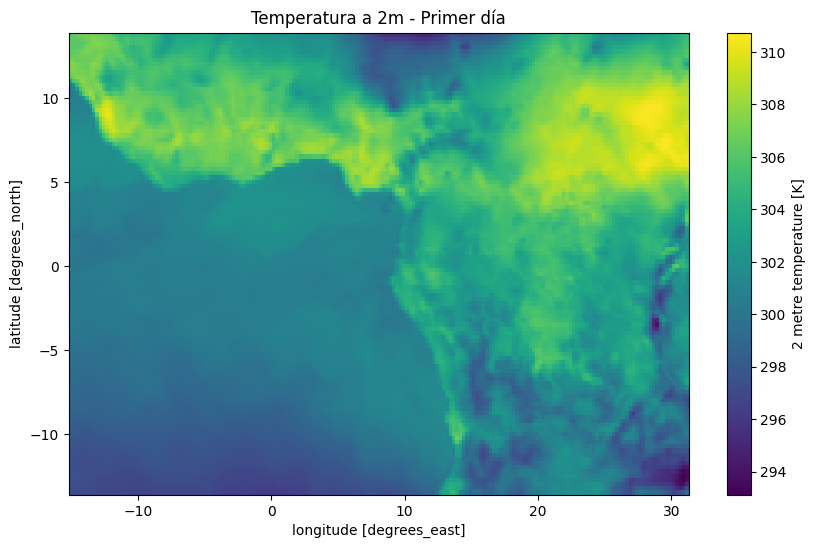

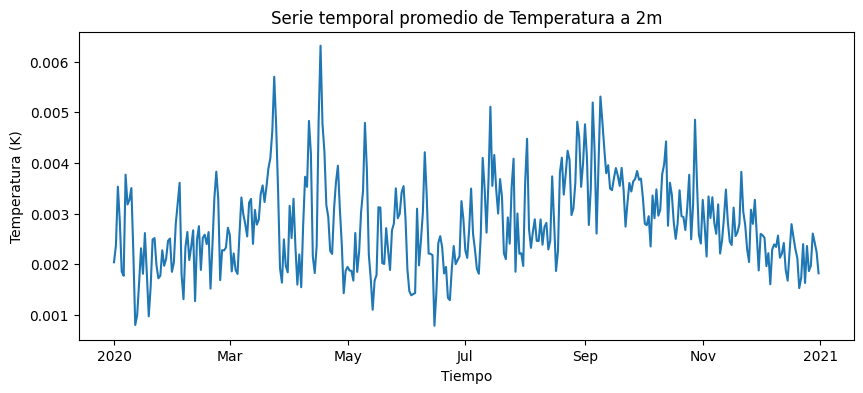

In [12]:
import xarray as xr
import matplotlib.pyplot as plt

# Abrir el dataset Zarr
ds = xr.open_zarr("era5_land_cacao_uniform.zarr")
print(ds)

# Ejemplo 1: Graficar un mapa de la temperatura a 2m (t2m) para el primer día del dataset
t2m_first = ds.t2m.isel(valid_time=0)
plt.figure(figsize=(10, 6))
t2m_first.plot(cmap="viridis")
plt.title("Temperatura a 2m - Primer día")
plt.show()

# Ejemplo 2: Graficar la serie temporal promedio de t2m para toda la región
t2m_mean = ds.tp.mean(dim=["latitude", "longitude"])
plt.figure(figsize=(10, 4))
t2m_mean.plot()
plt.title("Serie temporal promedio de Temperatura a 2m")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (K)")
plt.show()

INFO:__main__:Se encontraron 24 archivos NetCDF.
INFO:__main__:Datos diarios combinados:


<xarray.Dataset> Size: 60MB
Dimensions:     (valid_time: 366, latitude: 110, longitude: 186)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 880B 13.79 13.54 13.29 ... -13.21 -13.46
  * longitude   (longitude) float64 1kB -15.08 -14.83 -14.58 ... 30.92 31.17
  * valid_time  (valid_time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 30MB dask.array<chunksize=(31, 110, 186), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 30MB dask.array<chunksize=(31, 110, 186), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-14T23:24 GRIB to CDM+CF via cfgrib-0.9.1...


INFO:__main__:Parámetros ajustados de la distribución Fisk: (np.float64(0.44715830889605257), np.float64(-2.0050456557759375e-26), np.float64(3.0283449486008975))


<xarray.DataArray 'SPEI_weekly' (time: 53)> Size: 424B
array([ 1.24282953,  1.21998538,  1.20787524,  1.21358723,  1.21005888,
        1.1672519 ,  1.15334152,  1.13954208,  1.12757431,  0.97729178,
        1.04112799,  1.03946202,  1.00158074,  0.6713218 ,  0.88897809,
        0.88931164,  0.88141604,  0.85571167,  0.62461292,  0.4352666 ,
        0.7582241 ,  0.78710855, -6.9395317 ,  0.79396008,  0.85486954,
        0.89313129,  0.83403195,  0.92202905,  1.00137182,  0.96861539,
        0.97937655,  1.04262885,  0.98686959,  1.03398399,  1.04699592,
        1.11218489,  1.10096961,  1.08368772,  1.07719775,  1.04717332,
        1.13513605,  1.11220448,  1.10155545,  1.08697636,  1.19002213,
        1.19587747,  1.1935725 ,  1.18411764,  1.23291625,  1.22956096,
        1.23904597,  1.23352004,  1.22713333])
Coordinates:
  * time     (time) datetime64[ns] 424B 2020-01-01 2020-01-08 ... 2020-12-30


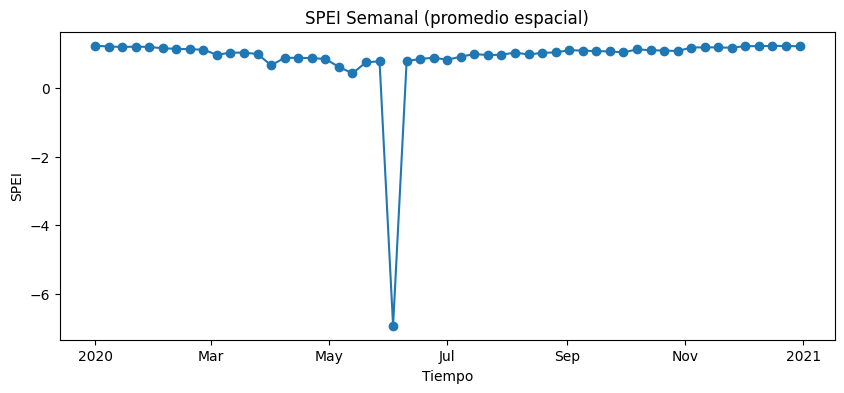

INFO:__main__:Guardando el dataset semanal en Zarr: era5_land_cacao_weekly.zarr ...
/Users/charly_1/Documents/GitHub/crop_analysis/.venv/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
INFO:__main__:Dataset guardado en Zarr: era5_land_cacao_weekly.zarr


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
from scipy.stats import fisk, norm

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Función simplificada de Thornthwaite para calcular PET (en mm/7 días)
def thornthwaite_pet(temp_c, month):
    """
    Calcula un PET aproximado usando una fórmula simplificada de Thornthwaite.
    temp_c : temperatura media en °C del periodo.
    month  : mes (1 a 12) para asignar un factor de duración del día.
    
    NOTA: Esta función es muy simplificada y solo se usa con fines ilustrativos.
    """
    # Aproximación de la duración media del día (en horas) para cada mes (valores aproximados)
    day_length = [9.5, 10.0, 11.0, 12.0, 13.0, 14.0, 14.5, 14.0, 13.0, 12.0, 10.5, 9.5]
    L = day_length[month - 1]
    # Usamos un valor fijo para el índice de calor I (en aplicaciones reales se calcula a partir de 12 meses de datos)
    I = 10.0
    # Exponente m fijo (la fórmula original lo hace dependiente de I)
    m = 1.6
    # Si la temperatura es menor o igual a 0°C, se supone que no hay PET
    if temp_c <= 0:
        return 0.0
    # Fórmula simplificada (para 7 días; es una adaptación)
    pet = 16 * (L / 12) * ((10 * temp_c / I) ** m) * (7/30)
    return pet

# Directorio de los archivos NetCDF (ya combinados o individualmente descargados)
input_dir = Path("data_inputs/climate_data")
nc_files = sorted(input_dir.glob("*.nc"))
logger.info(f"Se encontraron {len(nc_files)} archivos NetCDF.")

# Abrir los archivos diarios combinados usando xarray y Dask
ds = xr.open_mfdataset(
    [str(f) for f in nc_files],
    combine="by_coords",
    parallel=True,
    engine="h5netcdf"
)

logger.info("Datos diarios combinados:")
print(ds)

# Renombrar la dimensión 'valid_time' a 'time' si es necesario
if "valid_time" in ds.dims:
    ds = ds.rename({"valid_time": "time"})

# Reagrupar los datos diarios a ventanas de 7 días:
# - Precipitación: se suma (acumulación en 7 días)
# - Temperatura: se promedia (temperatura media en 7 días)
ds_tp_weekly = ds.tp.resample(time="7D").sum()
ds_t2m_weekly = ds.t2m.resample(time="7D").mean()

# Combinar ambos en un único Dataset semanal
ds_weekly = xr.merge([ds_tp_weekly, ds_t2m_weekly])

# Convertir la temperatura de Kelvin a Celsius
ds_weekly["t2m_c"] = ds_weekly["t2m"] - 273.15

# Calcular la media espacial (promedio sobre latitud y longitud) para cada 7 días
precip_weekly = ds_weekly["tp"].mean(dim=["latitude", "longitude"])
temp_weekly = ds_weekly["t2m_c"].mean(dim=["latitude", "longitude"])

# Extraer el número del mes para cada ventana semanal.
# Para simplificar, usamos el mes del primer día de cada ventana.
weeks_month = ds_weekly["time.month"]

# Calcular PET para cada ventana de 7 días usando la función simplificada
pet_values = []
for temp, month in zip(temp_weekly.values, weeks_month.values):
    pet_values.append(thornthwaite_pet(temp, month))
pet = np.array(pet_values)

# Calcular el balance hídrico: D = Precipitación - PET (en mm/7 días)
D = precip_weekly.values - pet

# Si D tiene valores negativos, se añade un pequeño desplazamiento para ajustar la distribución
D_min = D.min()
shift = 0.0
if D_min <= 0:
    shift = abs(D_min) + 1e-6
D_shifted = D + shift

# Ajustar la distribución log-logística (Fisk) a D_shifted
params = fisk.fit(D_shifted)
logger.info(f"Parámetros ajustados de la distribución Fisk: {params}")

# Calcular la función de distribución acumulada (CDF) para cada valor de D_shifted
F = fisk.cdf(D_shifted, *params)

# Transformar la CDF a un valor Z (SPEI) usando la inversa de la normal estándar
spei = norm.ppf(F)

# Crear un DataArray para el SPEI semanal usando la dimensión 'time'
spei_da = xr.DataArray(
    spei,
    dims=["time"],
    coords={"time": ds_weekly["time"]},
    name="SPEI_weekly"
)

# Agregar el SPEI al dataset semanal
ds_weekly["SPEI_weekly"] = spei_da

# Mostrar y graficar la serie temporal del SPEI semanal
print(spei_da)
plt.figure(figsize=(10, 4))
spei_da.plot(marker="o")
plt.title("SPEI Semanal (promedio espacial)")
plt.xlabel("Tiempo")
plt.ylabel("SPEI")
plt.show()

# Finalmente, guardar el dataset semanal (con SPEI incluido) en formato Zarr
output_zarr = "era5_land_cacao_weekly.zarr"
logger.info(f"Guardando el dataset semanal en Zarr: {output_zarr} ...")
ds_weekly.to_zarr(output_zarr, mode="w")
logger.info(f"Dataset guardado en Zarr: {output_zarr}")

In [2]:
import requests
from pathlib import Path
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Lista de URLs a descargar
urls = [
    "https://digital.csic.es/bitstream/10261/364137/01/spei01.nc",
    "https://digital.csic.es/bitstream/10261/364137/02/spei02.nc",
    "https://digital.csic.es/bitstream/10261/364137/03/spei03.nc",
    "https://digital.csic.es/bitstream/10261/364137/04/spei04.nc",
    "https://digital.csic.es/bitstream/10261/364137/05/spei05.nc",
    "https://digital.csic.es/bitstream/10261/364137/06/spei06.nc",
    "https://digital.csic.es/bitstream/10261/364137/07/spei07.nc",
    "https://digital.csic.es/bitstream/10261/364137/08/spei08.nc",
    "https://digital.csic.es/bitstream/10261/364137/09/spei09.nc",
    "https://digital.csic.es/bitstream/10261/364137/10/spei10.nc",
    "https://digital.csic.es/bitstream/10261/364137/11/spei11.nc",
    "https://digital.csic.es/bitstream/10261/364137/12/spei12.nc",
    "https://digital.csic.es/bitstream/10261/364137/13/spei13.nc",
    "https://digital.csic.es/bitstream/10261/364137/14/spei14.nc",
    "https://digital.csic.es/bitstream/10261/364137/15/spei15.nc",
    "https://digital.csic.es/bitstream/10261/364137/16/spei16.nc",
    "https://digital.csic.es/bitstream/10261/364137/17/spei17.nc",
    "https://digital.csic.es/bitstream/10261/364137/18/spei18.nc",
    "https://digital.csic.es/bitstream/10261/364137/19/spei19.nc",
    "https://digital.csic.es/bitstream/10261/364137/20/spei20.nc",
    "https://digital.csic.es/bitstream/10261/364137/21/spei21.nc",
    "https://digital.csic.es/bitstream/10261/364137/22/spei22.nc",
    "https://digital.csic.es/bitstream/10261/364137/23/spei23.nc",
    "https://digital.csic.es/bitstream/10261/364137/24/spei24.nc",
    "https://digital.csic.es/bitstream/10261/364137/25/spei25.nc",
    "https://digital.csic.es/bitstream/10261/364137/26/spei26.nc",
    "https://digital.csic.es/bitstream/10261/364137/27/spei27.nc",
    "https://digital.csic.es/bitstream/10261/364137/28/spei28.nc",
    "https://digital.csic.es/bitstream/10261/364137/29/spei29.nc",
    "https://digital.csic.es/bitstream/10261/364137/30/spei30.nc",
    "https://digital.csic.es/bitstream/10261/364137/31/spei31.nc",
    "https://digital.csic.es/bitstream/10261/364137/32/spei32.nc",
    "https://digital.csic.es/bitstream/10261/364137/33/spei33.nc",
    "https://digital.csic.es/bitstream/10261/364137/34/spei34.nc",
    "https://digital.csic.es/bitstream/10261/364137/35/spei35.nc",
    "https://digital.csic.es/bitstream/10261/364137/36/spei36.nc",
    "https://digital.csic.es/bitstream/10261/364137/37/spei37.nc",
    "https://digital.csic.es/bitstream/10261/364137/48/spei38.nc",
    "https://digital.csic.es/bitstream/10261/364137/38/spei39.nc",
    "https://digital.csic.es/bitstream/10261/364137/39/spei40.nc",
    "https://digital.csic.es/bitstream/10261/364137/40/spei41.nc",
    "https://digital.csic.es/bitstream/10261/364137/41/spei42.nc",
    "https://digital.csic.es/bitstream/10261/364137/42/spei43.nc",
    "https://digital.csic.es/bitstream/10261/364137/43/spei44.nc",
    "https://digital.csic.es/bitstream/10261/364137/44/spei45.nc",
    "https://digital.csic.es/bitstream/10261/364137/45/spei46.nc",
    "https://digital.csic.es/bitstream/10261/364137/46/spei47.nc",
    "https://digital.csic.es/bitstream/10261/364137/47/spei48.nc",
]

# Directorio de salida
output_dir = Path("data_inputs/spei_downloads")
output_dir.mkdir(parents=True, exist_ok=True)

def download_file(url):
    local_filename = output_dir / url.split("/")[-1]
    try:
        logger.info(f"Descargando {url} ...")
        with requests.get(url, stream=True) as response:
            response.raise_for_status()  # Genera error si la descarga falla
            with open(local_filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        logger.info(f"Descargado: {local_filename}")
    except Exception as e:
        logger.error(f"Error descargando {url}: {e}")

# Usar ThreadPoolExecutor para descargas en paralelo
max_workers = 8  # Puedes ajustar este número según tu conexión y recursos
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(download_file, url) for url in urls]
    for future in as_completed(futures):
        try:
            future.result()
        except Exception as e:
            logger.error(f"Error en una tarea de descarga: {e}")

INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/01/spei01.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/02/spei02.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/03/spei03.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/04/spei04.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/05/spei05.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/06/spei06.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/07/spei07.nc ...
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/08/spei08.nc ...
INFO:__main__:Descargado: data_inputs/spei_downloads/spei02.nc
INFO:__main__:Descargando https://digital.csic.es/bitstream/10261/364137/09/spei09.nc ...
INFO:__main__:Descargado: data_inputs/spei_downloads/spei03.nc
INFO:__main__:Descargando https://digital.csic.es/bitstream/1026

In [1]:
from dask.distributed import Client, LocalCluster

# Inicia un clúster local con configuración por defecto
cluster = LocalCluster()

# Crea un cliente que se conecta al clúster
client = Client(cluster)

# Muestra la URL del dashboard
print("Dashboard Dask:", client.dashboard_link)

Dashboard Dask: http://127.0.0.1:8787/status


In [15]:
import xarray as xr
from pathlib import Path
import logging

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Directorio donde se encuentran los archivos NetCDF
input_dir = Path("data_inputs/spei_downloads")
nc_files = sorted(input_dir.glob("*.nc"))
logger.info(f"Se encontraron {len(nc_files)} archivos NetCDF.")

# Abrir todos los archivos combinados con xarray
ds = xr.open_mfdataset(
    [str(f) for f in nc_files],
    combine="by_coords",
    parallel=True,
    engine="h5netcdf"
)

# Opcional: Rechunkar para obtener chunks uniformes (por ejemplo, en la dimensión 'time')
ds = ds.chunk({"time": 30})  # Ajusta el tamaño de chunk según tus necesidades

# Guardar el dataset combinado en formato Zarr
output_zarr = "era5_land_combined.zarr"
logger.info(f"Guardando el dataset combinado en Zarr: {output_zarr} ...")
ds.to_zarr(output_zarr, mode="w")
logger.info(f"Guardado en Zarr: {output_zarr}")

INFO:__main__:Se encontraron 48 archivos NetCDF.


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [10]:
ds= xr.open_dataset("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/spei_downloads/spei05.nc")

In [29]:
import pandas as pd

n_time = len(ds.time)
new_time = pd.date_range("1901-01-01", periods=n_time, freq="D")
ds = spei.assign_coords(time=new_time)

AttributeError: 'Dataset' object has no attribute 'time'

In [30]:
import xarray as xr
from pathlib import Path
import logging
import re

# Configurar logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Directorio de los archivos NetCDF SPEI
input_dir = Path("data_inputs/spei_downloads")
nc_files = sorted(input_dir.glob("*.nc"))
logger.info(f"Se encontraron {len(nc_files)} archivos NetCDF en {input_dir}")

# Lista para almacenar los datasets abiertos de forma lazy
datasets = []

# Abrir cada archivo utilizando dask (con chunks) para no cargar todo en memoria
for f in nc_files:
    try:
        ds = xr.open_dataset(f, engine="h5netcdf", chunks={"time": 1, "latitude": 50, "longitude": 50})
        # Si no tiene coordenada 'time', la creamos a partir del nombre del archivo
        import pandas as pd

        if "time" not in ds.coords:
            # Supongamos que el nombre es "spei202001.nc" y queremos usar el primer día de ese mes.
            match = re.search(r"spei(\d{4})(\d{2})\.nc", f.name)
            if match:
                year = int(match.group(1))
                month = int(match.group(2))
                # Crear una fecha representativa, por ejemplo, el primer día del mes
                time_val = pd.Timestamp(year=year, month=month, day=1)
            else:
                time_val = pd.NaT
            ds = ds.expand_dims({"time": [time_val]})
        datasets.append(ds)
        logger.info(f"{f} OK")
    except Exception as e:
        logger.error(f"Error abriendo {f}: {e}")

if not datasets:
    raise ValueError("No se pudieron abrir archivos válidos.")

# Concatenar los datasets a lo largo de la dimensión "time" de forma lazy
try:
    ds_combined = xr.concat(datasets, dim="time")
    logger.info("Datasets concatenados correctamente.")
except Exception as e:
    logger.error(f"Error al concatenar los datasets: {e}")
    raise

# Opcional: rechunkar para uniformizar la dimensión 'time'
ds_combined = ds_combined.chunk({"time": 10})

# Guardar el dataset combinado en formato Zarr sin cargar todos los datos en memoria
output_zarr = "spei_combined.zarr"
logger.info(f"Guardando dataset combinado en Zarr: {output_zarr} ...")
ds_combined.to_zarr(output_zarr, mode="w")
logger.info(f"Dataset guardado en Zarr: {output_zarr}")

INFO:__main__:Se encontraron 48 archivos NetCDF en data_inputs/spei_downloads


INFO:__main__:data_inputs/spei_downloads/spei01.nc OK
INFO:__main__:data_inputs/spei_downloads/spei02.nc OK
INFO:__main__:data_inputs/spei_downloads/spei03.nc OK
INFO:__main__:data_inputs/spei_downloads/spei04.nc OK
INFO:__main__:data_inputs/spei_downloads/spei05.nc OK
INFO:__main__:data_inputs/spei_downloads/spei06.nc OK
INFO:__main__:data_inputs/spei_downloads/spei07.nc OK
INFO:__main__:data_inputs/spei_downloads/spei08.nc OK
INFO:__main__:data_inputs/spei_downloads/spei09.nc OK
INFO:__main__:data_inputs/spei_downloads/spei10.nc OK
INFO:__main__:data_inputs/spei_downloads/spei11.nc OK
INFO:__main__:data_inputs/spei_downloads/spei12.nc OK
INFO:__main__:data_inputs/spei_downloads/spei13.nc OK
INFO:__main__:data_inputs/spei_downloads/spei14.nc OK
INFO:__main__:data_inputs/spei_downloads/spei15.nc OK
INFO:__main__:data_inputs/spei_downloads/spei16.nc OK
INFO:__main__:data_inputs/spei_downloads/spei17.nc OK
INFO:__main__:data_inputs/spei_downloads/spei18.nc OK
INFO:__main__:data_inputs/sp

KeyboardInterrupt: 

In [ ]:
from dask.distributed import Client, LocalCluster

# Inicia un clúster local con configuración por defecto
cluster = LocalCluster()

# Crea un cliente que se conecta al clúster
client = Client(cluster)

# Muestra la URL del dashboard
print("Dashboard Dask:", client.dashboard_link)

Dashboard Dask: http://127.0.0.1:8787/status


2025-03-15 06:00:36,966 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:49427' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('store-map-94fa9de850f0cbd5b727e9e421752573', 7022, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 6489, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 5635, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 4106, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 6722, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 6004, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 5008, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 4708, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 92, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 6083, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 5377, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 4832, 0, 0), ('store-map-94fa9de850f0cbd5b727e9e421752573', 4523, 0, 0), ('store-map-94fa9de850f0cbd5b727

In [2]:
import xarray as xr
from pathlib import Path
import logging
import re

# Configurar logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Directorio de los archivos NetCDF SPEI
input_dir = Path("data_inputs/spei_downloads")
nc_files = sorted(input_dir.glob("*.nc"))
logger.info(f"Se encontraron {len(nc_files)} archivos NetCDF en {input_dir}")

# Lista para almacenar los datasets abiertos de forma lazy
datasets = []

# Abrir cada archivo utilizando dask (con chunks) para no cargar todo en memoria
for f in nc_files:
    try:
        ds = xr.open_dataset(f, engine="h5netcdf", chunks={"time": 1, "latitude": 50, "longitude": 50})
        # Si no tiene coordenada 'time', la creamos a partir del nombre del archivo
        if "time" not in ds.coords:
            # Se asume nombre del tipo "speiXX.nc"
            match = re.search(r"spei(\d+)\.nc", f.name)
            if match:
                time_val = int(match.group(1))
            else:
                time_val = None
            ds = ds.expand_dims({"time": [time_val]})
        datasets.append(ds)
        logger.info(f"{f} OK")
    except Exception as e:
        logger.error(f"Error abriendo {f}: {e}")

if not datasets:
    raise ValueError("No se pudieron abrir archivos válidos.")

# Concatenar los datasets a lo largo de la dimensión "time" de forma lazy
try:
    ds_combined = xr.concat(datasets, dim="time")
    logger.info("Datasets concatenados correctamente.")
except Exception as e:
    logger.error(f"Error al concatenar los datasets: {e}")
    raise

# Opcional: rechunkar para uniformizar la dimensión 'time'
ds_combined = ds_combined.chunk({"time": 10})

# Guardar el dataset combinado en formato Zarr sin cargar todos los datos en memoria
output_zarr = "spei_combined.zarr"
logger.info(f"Guardando dataset combinado en Zarr: {output_zarr} ...")
ds_combined.to_zarr(output_zarr, mode="w")
logger.info(f"Dataset guardado en Zarr: {output_zarr}")

INFO:__main__:Se encontraron 48 archivos NetCDF en data_inputs/spei_downloads
INFO:__main__:data_inputs/spei_downloads/spei01.nc OK
INFO:__main__:data_inputs/spei_downloads/spei02.nc OK
INFO:__main__:data_inputs/spei_downloads/spei03.nc OK
INFO:__main__:data_inputs/spei_downloads/spei04.nc OK
INFO:__main__:data_inputs/spei_downloads/spei05.nc OK
INFO:__main__:data_inputs/spei_downloads/spei06.nc OK
INFO:__main__:data_inputs/spei_downloads/spei07.nc OK
INFO:__main__:data_inputs/spei_downloads/spei08.nc OK
INFO:__main__:data_inputs/spei_downloads/spei09.nc OK
INFO:__main__:data_inputs/spei_downloads/spei10.nc OK
INFO:__main__:data_inputs/spei_downloads/spei11.nc OK
INFO:__main__:data_inputs/spei_downloads/spei12.nc OK
INFO:__main__:data_inputs/spei_downloads/spei13.nc OK
INFO:__main__:data_inputs/spei_downloads/spei14.nc OK
INFO:__main__:data_inputs/spei_downloads/spei15.nc OK
INFO:__main__:data_inputs/spei_downloads/spei16.nc OK
INFO:__main__:data_inputs/spei_downloads/spei17.nc OK
INFO

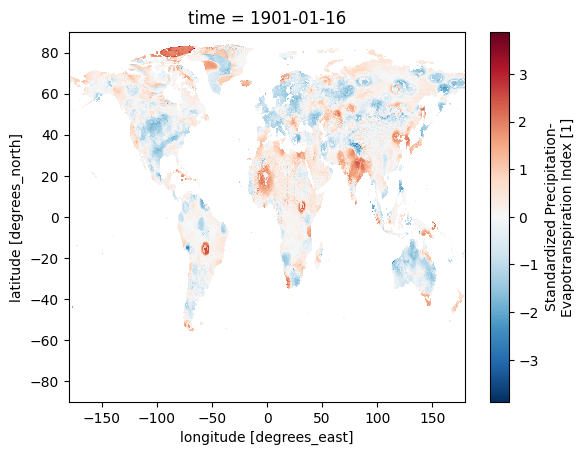

In [10]:
ds_combined.isel(time=0).spei.plot()

<xarray.Dataset> Size: 415MB
Dimensions:   (lon: 7200, lat: 3600)
Coordinates:
  * lon       (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat       (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
Data variables:
    harvarea  (lat, lon) float32 104MB ...
    croparea  (lat, lon) float32 104MB ...
    qual      (lat, lon) float32 104MB ...
    set       (lat, lon) float32 104MB ...
Attributes:
    Creation date:  10-Mar-2024 09:39:23
    Authors:        F. Maggi, F.H.M. Tang, T.H. Nguyen
    Version:        v1.08


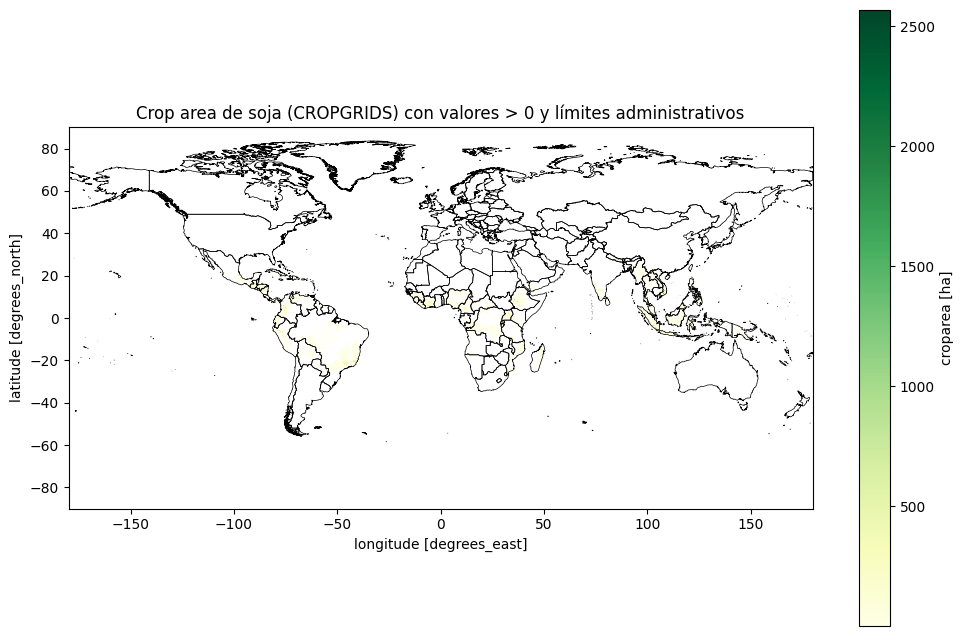

In [16]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# Ruta al archivo netCDF de rendimientos
nc_file = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_coffee.nc"

# Abrir el dataset netCDF
ds = xr.open_dataset(nc_file)
print(ds)  # Para inspeccionar las variables disponibles

# Supongamos que la variable de interés es 'croparea'. 
# Si tiene otro nombre, reemplazar 'croparea' por el nombre adecuado.
soybean_yield = ds['croparea']

# Enmascarar valores menores o iguales a cero
soybean_yield = soybean_yield.where(soybean_yield > 0)

# Crear la figura y eje para el plot
fig, ax = plt.subplots(figsize=(12, 8))

# Ploteamos la variable de rendimiento, solo mostrando valores > 0
soybean_yield.plot(ax=ax, cmap="YlGn", add_colorbar=True)

# Ruta al archivo GeoJSON de límites administrativos
geojson_file = "/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.geojson"

# Cargar el shapefile con geopandas
world_boundaries = gpd.read_file(geojson_file)

# Asegurarse de que ambos datasets tengan el mismo CRS (se asume EPSG:4326)
world_boundaries = world_boundaries.to_crs(epsg=4326)

# Ploteamos los límites administrativos sobre el raster
world_boundaries.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

ax.set_title("Crop area de soja (CROPGRIDS) con valores > 0 y límites administrativos")
plt.show()

In [18]:
import requests
import json

# Endpoint de Climate Engine (reemplaza si fuera necesario el host o versión)
url = "https://api.climateengine.org/metadata/percentiles_std_index_metadata/raster_percentiles_standard_index"

# Parámetros que requieras enviar (ajústalos según la documentación)
params = {
    "dataset": "CMORPH_DAILY",   # Ejemplo: identifica el dataset
    "variable": "SPI",           # Ejemplo: la variable de interés
    # Puedes agregar otros parámetros si son requeridos por la API
}

# Si la API requiere autenticación, incluye el header de autorización:
# headers = {"Authorization": "Bearer TU_API_KEY"}
# En este ejemplo, asumiremos que no es necesario

response = requests.get(url, params=params)  # , headers=headers

if response.status_code == 200:
    data = response.json()
    # Imprime la respuesta de forma legible
    print(json.dumps(data, indent=4))
    # O guarda la respuesta en un archivo JSON
    with open("metadata_spi.json", "w") as f:
        json.dump(data, f, indent=4)
else:
    print("Error en la solicitud:", response.status_code, response.text)

Error en la solicitud: 404 {"detail":"Not Found"}
